In [1]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR


# Download the Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets","housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    os.makedirs(housing_path,exist_ok = True) # Creates folder named datasets with another folder inside names datasets
    tgz_path = os.path.join(housing_path,"housing.tgz") # creates path url for housing dataset in .tgz format
    urllib.request.urlretrieve(housing_url,tgz_path) # requests to retrieve dataset from housing url and place it in the path
    housing_tgz = tarfile.open(tgz_path) # opens .tgz file
    housing_tgz.extractall(path=housing_path) # extracts csv file from .tgz file
    housing_tgz.close() # closes .tgz file



In [4]:
def load_housing_data(housing_path = HOUSING_PATH):
    csv_path = os.path.join(housing_path,'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()

In [6]:
dataset = load_housing_data()

In [7]:
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


- 10 attributes
    - longitude
    - latitude
    - housing_median_age
    - total_rooms
    - total_bedrooms (few missing values)
    - population
    - households
    - median_income
    - median_house_value
    - ocean_proximity (non-numeric)

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
dataset['ocean_proximity'].value_counts()

# One-Hot encode?

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a177e0450>,
      dtype=object)

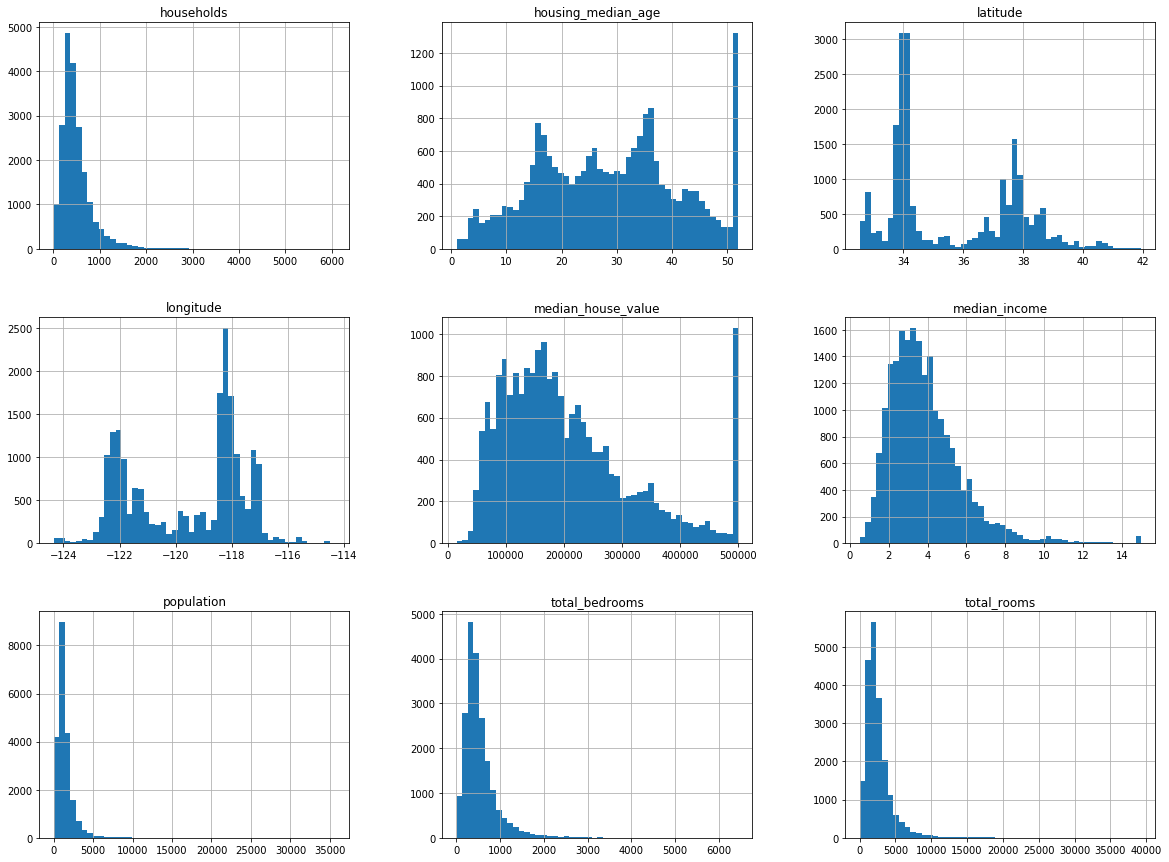

In [11]:
dataset.hist(bins=50,figsize=(20,15))

- Median Income is expressed in tens of thousands of dollars (ex: 3 is 30,000)
- Median House Value is capped at 500k
- Feature Scaling may be needed (various ranges)
- Feature Normalizing may be needed (skewed attributes)

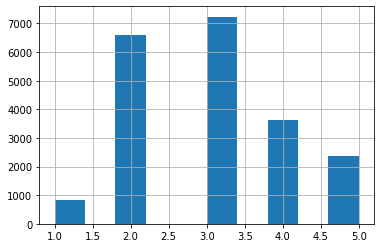

In [12]:
dataset['income_category'] = pd.cut(dataset['median_income'],
                                   bins = [0.,1.5,3.0,4.5,6.,np.inf],
                                   labels = [1,2,3,4,5])
dataset['income_category'].hist()

In [13]:
dataset['income_category'].value_counts() / len(dataset)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_category, dtype: float64

# Create a Unbiased Test Set

In [14]:
split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(dataset,dataset['income_category']):
    strat_train = dataset.loc[train_index]
    strat_test = dataset.loc[test_index]

In [15]:
strat_test['income_category'].value_counts() / len(strat_test)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_category, dtype: float64

In [16]:
for row in (strat_train,strat_test):
    row.drop('income_category',axis=1,inplace=True)

In [17]:
dataset = strat_train.copy()

# Discover and Visualize the Data to Gain Insights

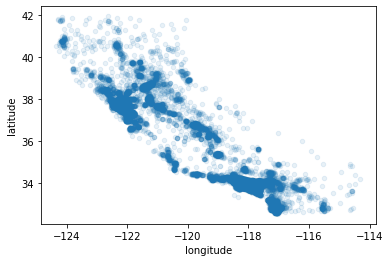

In [18]:
dataset.plot(kind='scatter',x='longitude',y='latitude',alpha=0.1)

- Mainly the Bay Area,LA,and SD
- Scattered along Central Valley, especially in Sac and Fresno

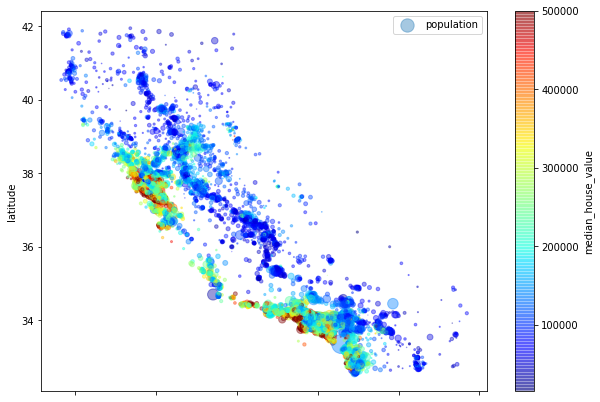

In [19]:
dataset.plot(kind='scatter',
             x='longitude',
             y='latitude',
             alpha=0.4,
             s= dataset['population']/100,
             label = 'population',
             figsize = (10,7),
             c='median_house_value',
             cmap = plt.get_cmap("jet"),
             colorbar = True)


- Bay Area, LA, SD (coastal cities) most expensive along with Sac 
- Ocean Proximity might play a bigger factor

# Looking for Correlations

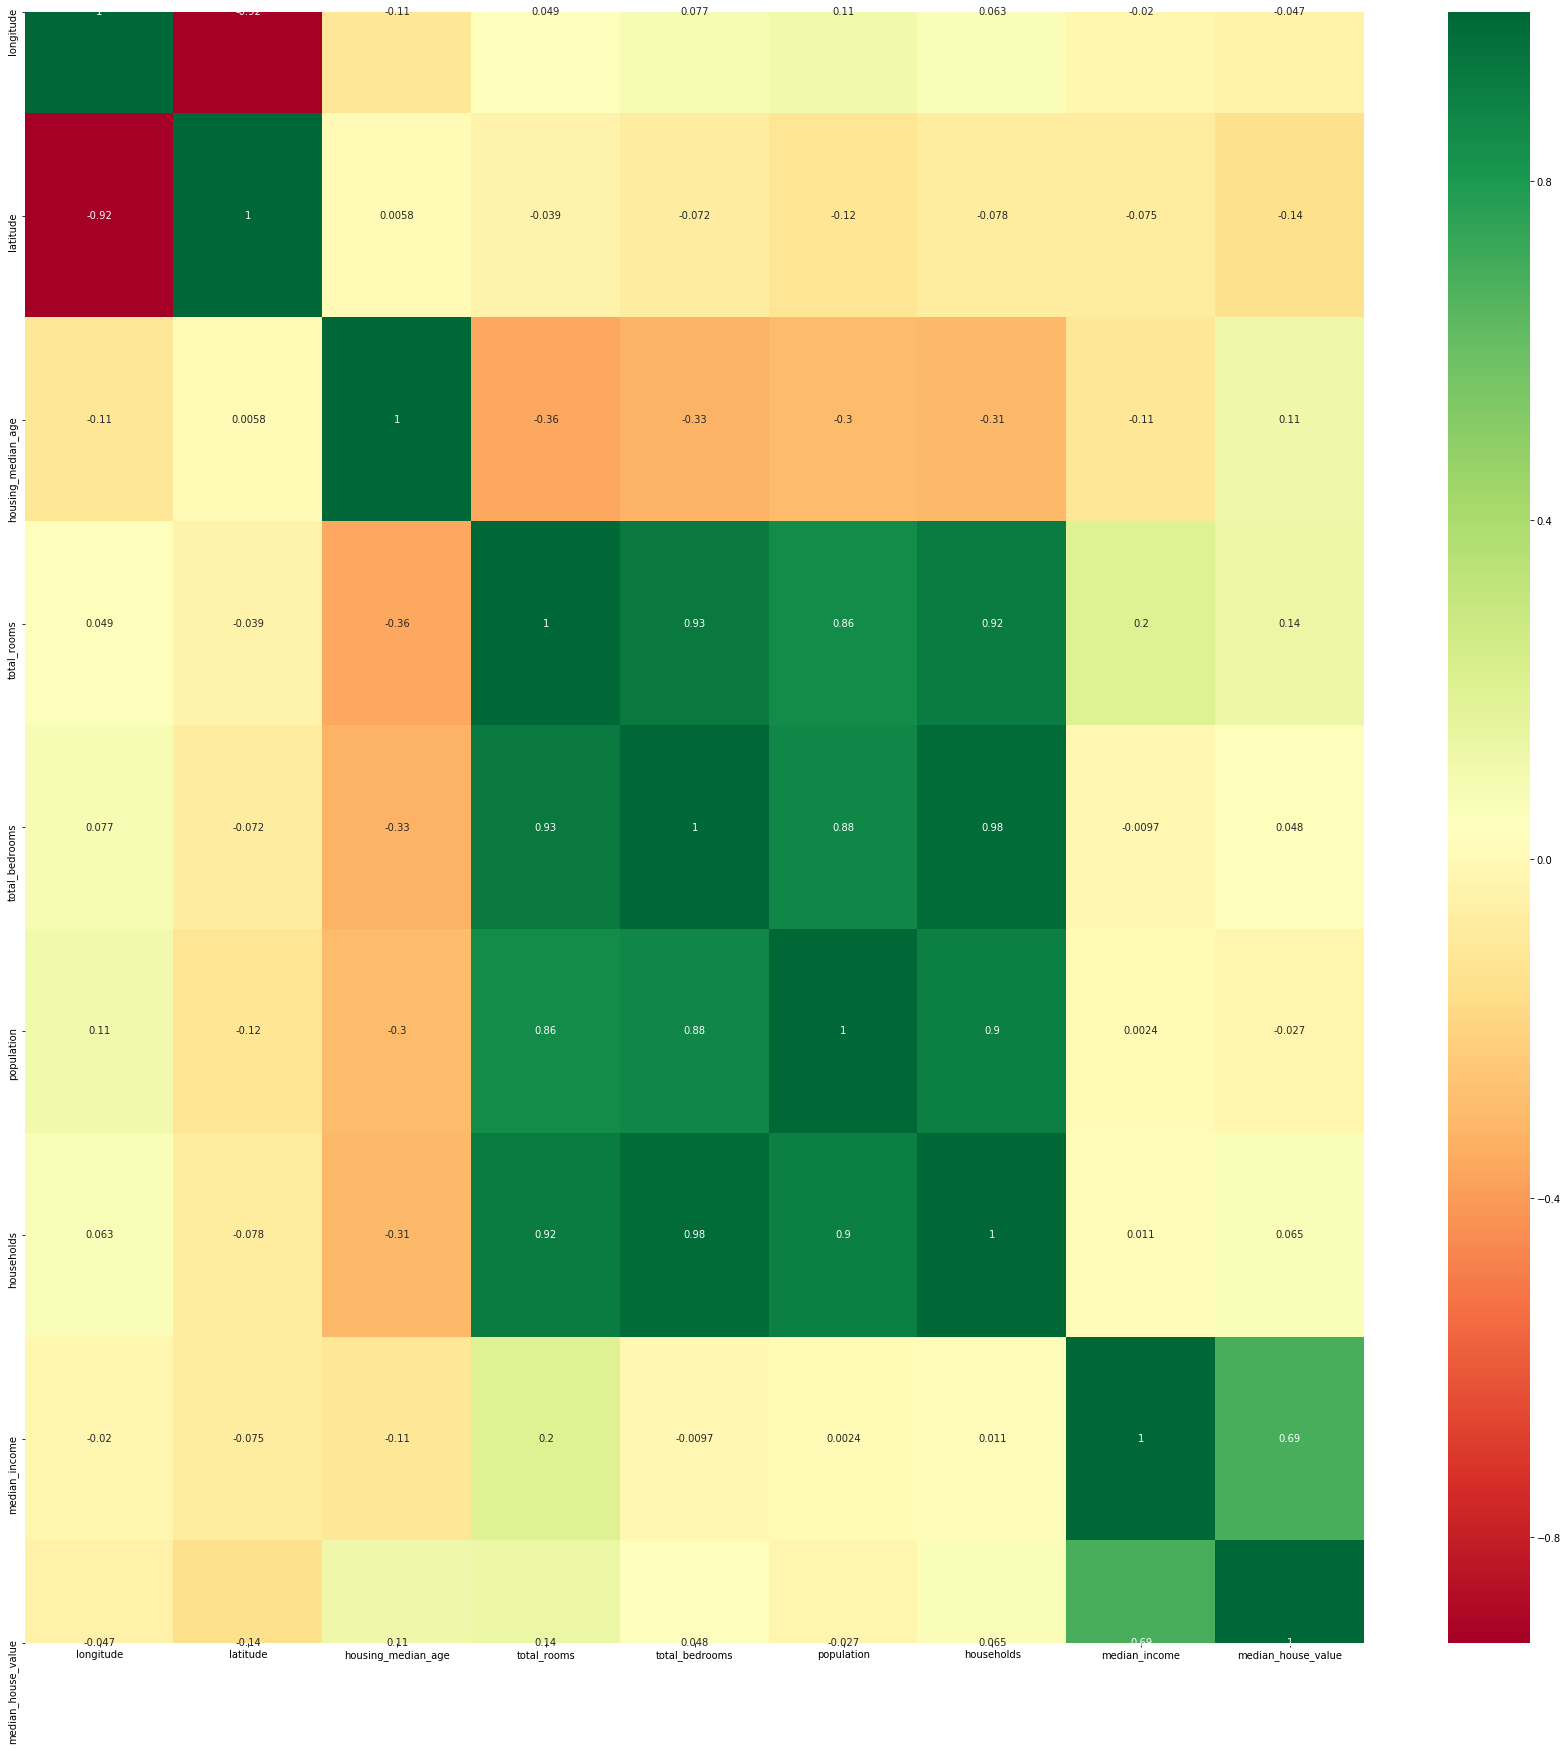

In [20]:
# Correlation Analysis
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (30,30))
g = sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

- Seems like Median Income has the highest correlation with Median House Value

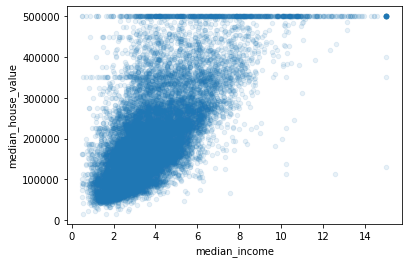

In [21]:
dataset.plot(kind='scatter',x='median_income',y='median_house_value',alpha=0.1)

- Highly Correlated
- Horizontal Bars at 500k,450k,350k,280k (try to avoid computer learning and replicating those)

# Experimenting with Attribute Combinations

In [22]:
dataset['rooms_per_household'] = dataset['total_rooms'] / dataset['households']
dataset['bedrooms_per_room'] = dataset['total_bedrooms'] / dataset['total_rooms']
dataset['population_per_household'] = dataset['population'] / dataset['households']

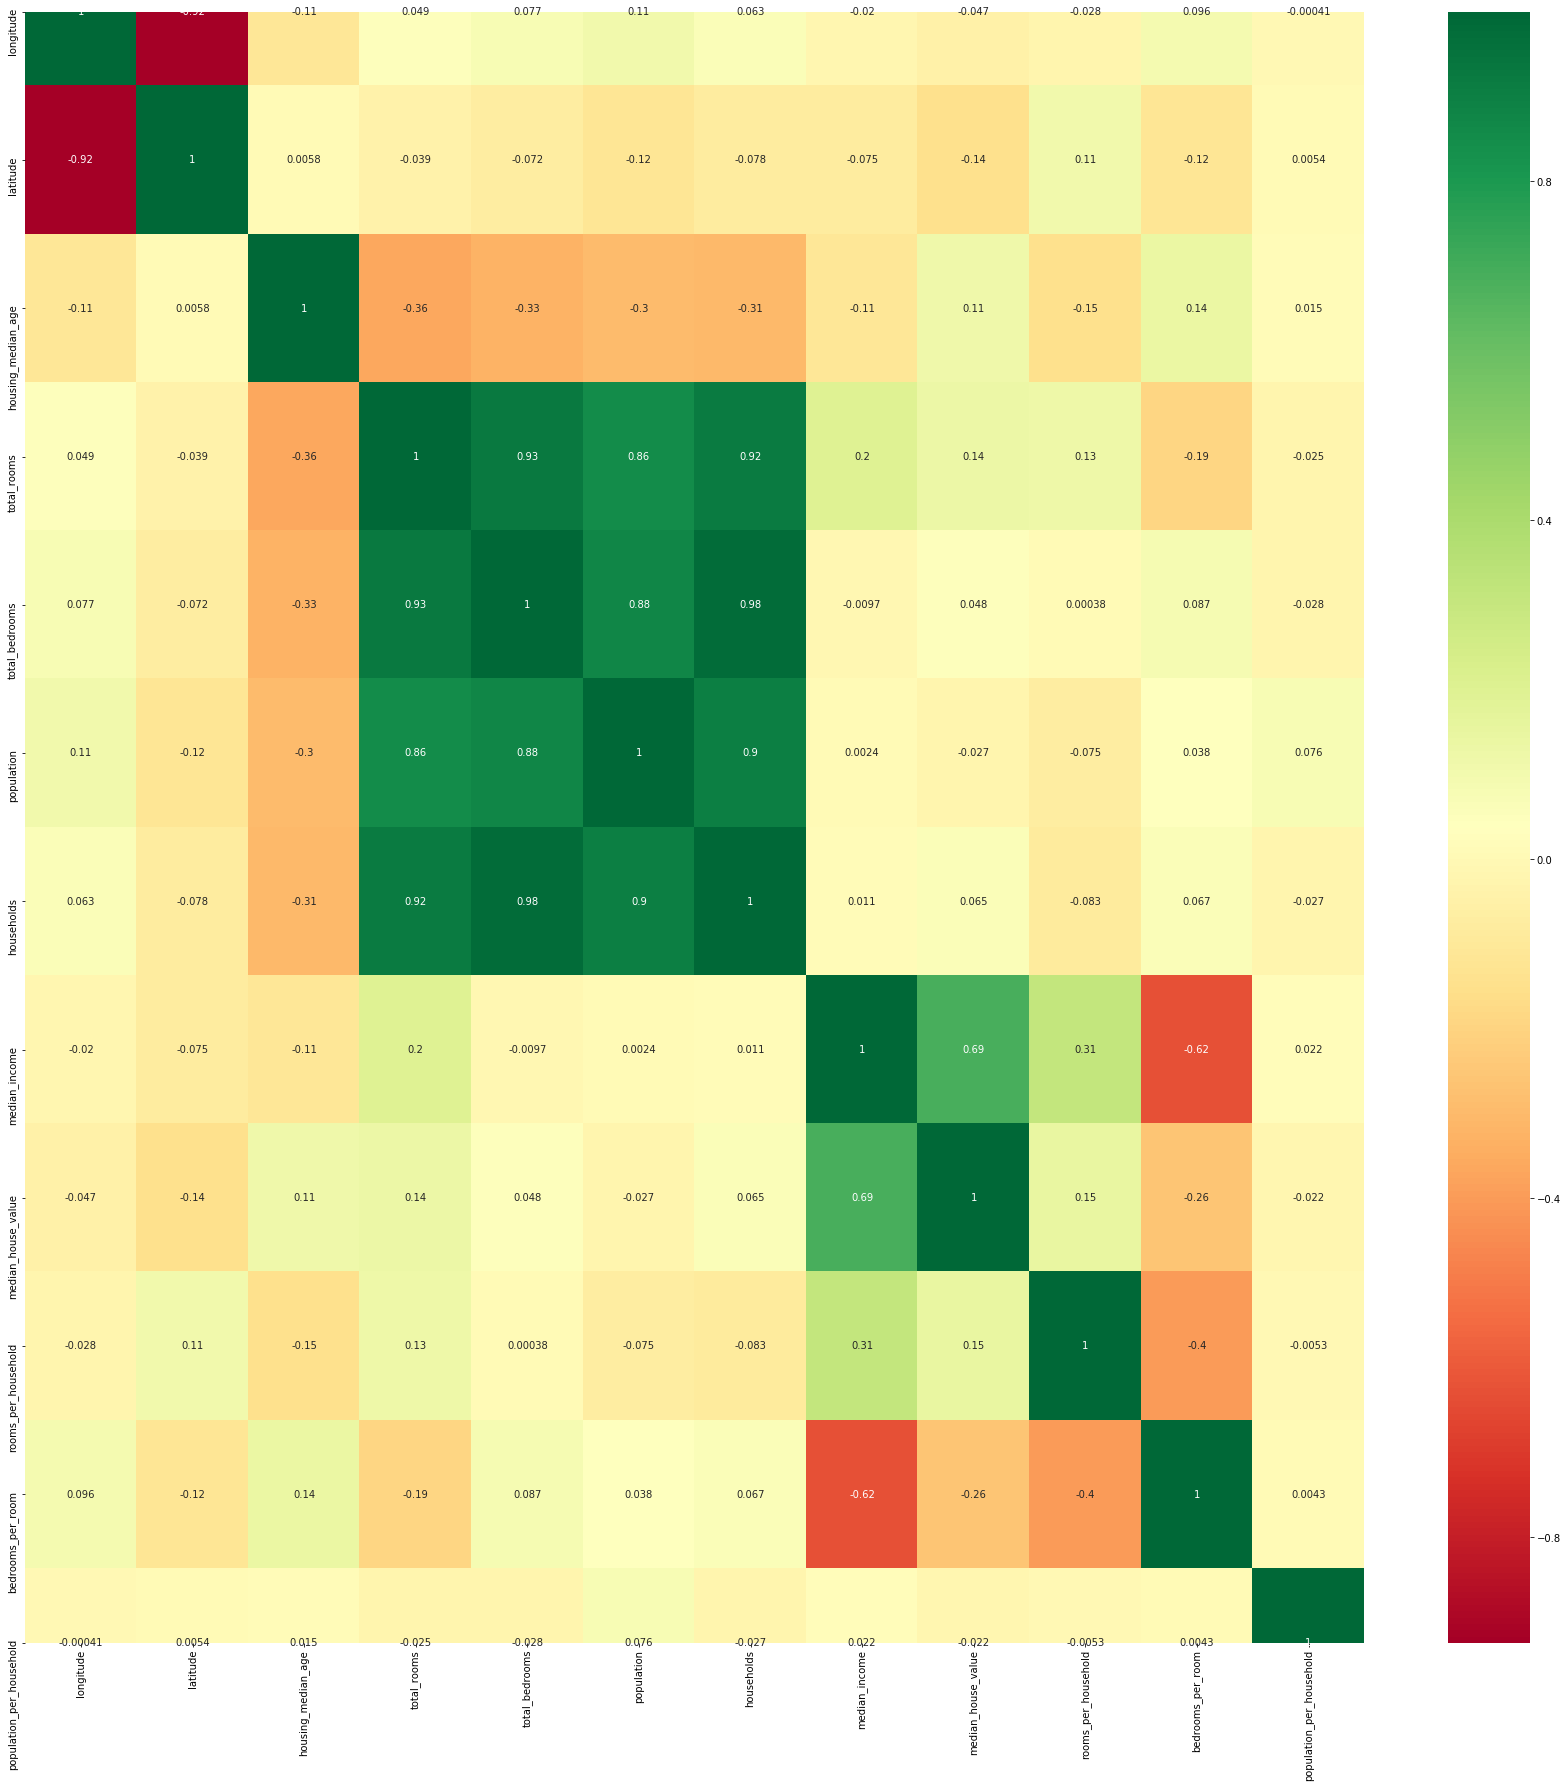

In [23]:
corrmat = dataset.corr()
top_corr_features = corrmat.index
plt.figure(figsize = (30,30))
g = sns.heatmap(dataset[top_corr_features].corr(),annot=True,cmap="RdYlGn")

- Aggregated feature of Bedrooms per Room correlates better with Median Income than separate features of bedrooms and rooms

# Prepare the Data For Machine Learning Algorithms

In [24]:
dataset = strat_train.drop('median_house_value',axis = 1)
labels = strat_train['median_house_value'].copy()

 Data Cleaning

In [25]:
imputer = SimpleImputer(strategy='median')
dataset_numeric = dataset.drop('ocean_proximity',axis=1)
X = imputer.fit_transform(dataset_numeric)
dataset_cleaned = pd.DataFrame(X,columns = dataset_numeric.columns, index = dataset_numeric.index)

In [26]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Handling Text and Categorical Attributes

In [27]:
dataset_category = dataset[['ocean_proximity']]
category_encoder = OneHotEncoder()
dataset_category_encoded = category_encoder.fit_transform(dataset_category)
dataset_category_encoded

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [28]:
rooms_ix,bedrooms_ix,population_ix,households_ix = 3,4,5,6

        
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


In [29]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = False)
housing_extra_attributes = attr_adder.transform(dataset.values)

Transformation Pipeline with Feature Scaling

In [30]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler',StandardScaler()),
])


In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [32]:
numeric_attributes = list(dataset_numeric)
category_attributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num',numeric_pipeline,numeric_attributes),
    ('cat',OneHotEncoder(),category_attributes),
])

dataset_prepared = full_pipeline.fit_transform(dataset)

# Selecting and Training a Model

In [33]:
len(labels)

16512

In [34]:
line_reg = LinearRegression()
line_reg.fit(dataset_prepared,labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
housing_preds = line_reg.predict(dataset_prepared)
line_mse = mean_squared_error(labels,housing_preds)
lin_rmse = np.sqrt(line_mse)
lin_rmse

68628.19819848923

Median Housing Values range between 120,000 and 265,000 and Linear Regression is off by around 68,628 (Underfitting)

In [36]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(dataset_prepared,labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [37]:
housing_preds = tree_reg.predict(dataset_prepared)
line_mse = mean_squared_error(labels,housing_preds)
lin_rmse = np.sqrt(line_mse)
lin_rmse

0.0

Decision Tree is off by 0 (Overfitting?)

Test by K-Fold Cross Validation

In [38]:
scores = cross_val_score(tree_reg,dataset_prepared,labels,scoring="neg_mean_squared_error",cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([70355.1154726 , 67262.61350457, 71109.70358077, 68149.25817988,
       71259.17113204, 74994.06052342, 69648.4424196 , 71733.4791253 ,
       77571.8369567 , 69740.57605813])

In [39]:
def display_scores(scores):
    print("Scores:",scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [40]:
display_scores(tree_rmse_scores)

Scores: [70355.1154726  67262.61350457 71109.70358077 68149.25817988
 71259.17113204 74994.06052342 69648.4424196  71733.4791253
 77571.8369567  69740.57605813]
Mean: 71182.42569530162
Standard Deviation: 2921.463411357042


In [41]:
lin_scores = cross_val_score(line_reg,dataset_prepared,labels,scoring="neg_mean_squared_error",cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard Deviation: 2731.674001798349


Turns out, Decision Trees are overfitting worse than Linear Regression is underfitting

In [42]:
forest_reg = RandomForestRegressor()
forest_reg.fit(dataset_prepared,labels)
forest_reg_scores = cross_val_score(forest_reg,dataset_prepared,labels,scoring="neg_mean_squared_error",cv=10)
forest_rmse_scores = np.sqrt(-forest_reg_scores)
display_scores(forest_rmse_scores)

/Users/ayusharora/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Scores: [52600.26751248 50297.62669837 52433.07066237 54874.19330409
 51922.57954895 55184.86020142 50922.47009921 50746.75563014
 54207.63317972 53754.60334669]
Mean: 52694.40601834556
Standard Deviation: 1664.8793901166293


Random Forest performs much better since it generates multiple decision trees and averages out the predictions

In [43]:
forest_reg_preds = forest_reg.predict(dataset_prepared)
forest_mse = mean_squared_error(labels,forest_reg_preds)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22452.502146335206

Training Error (22154) is significantly lower than Validation Error (52704)
Meaning that the model is still overfitting on the training set, but to a lower degree than LR and DT

# Fine-Tune Your Model

Grid Search:

In [44]:
param_grid = [
    {'n_estimators': [3,10,30],
    'max_features': [2,4,6,8]},
    {'bootstrap':[False],
    'n_estimators':[3,10],
    'max_features':[2,3,4]},
]

grid_search = GridSearchCV(forest_reg,param_grid,cv=5,scoring='neg_mean_squared_error',return_train_score=True)

grid_search.fit(dataset_prepared,labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=10, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],
    

In [45]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(np.sqrt(-mean_score),params)

63215.86694376324 {'max_features': 2, 'n_estimators': 3}
55343.169862514114 {'max_features': 2, 'n_estimators': 10}
53060.1607019035 {'max_features': 2, 'n_estimators': 30}
60333.3765064092 {'max_features': 4, 'n_estimators': 3}
53024.87305610179 {'max_features': 4, 'n_estimators': 10}
50575.614611622324 {'max_features': 4, 'n_estimators': 30}
59031.53876447215 {'max_features': 6, 'n_estimators': 3}
51981.509441395276 {'max_features': 6, 'n_estimators': 10}
50030.87629136693 {'max_features': 6, 'n_estimators': 30}
59046.05834379257 {'max_features': 8, 'n_estimators': 3}
51853.71155884859 {'max_features': 8, 'n_estimators': 10}
50060.51643235243 {'max_features': 8, 'n_estimators': 30}
63074.51726243538 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54792.443399447046 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
58142.38707377556 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52578.879609181364 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [46]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [47]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Best Hyperparameters are 6 max features and 30 n estimators since its error is the lowest at 49920

In [48]:
final_model = grid_search.best_estimator_

X_test = strat_test.drop("median_house_value",axis = 1)
y_test = strat_test['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_preds = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test,final_preds)
final_mse = np.sqrt(final_mse)
final_mse

47949.24967185048

In [49]:
from scipy import stats

confidence = 0.95
squared_errors = (final_preds - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc = squared_errors.mean(), scale = stats.sem(squared_errors)))

array([45926.71168943, 49889.86111007])